In [10]:
import gym
import numpy as np
import sys
from collections import defaultdict

env = gym.make('Blackjack-v1')
#env = env.unwrapped

num_episodes = 100000
gamma = 1.0
epsilon = 0.2

returns_sum = defaultdict(float)
returns_count = defaultdict(float)
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)

def first_visit_update(episode):
    G = 0
    used = set()
    for idx, (state, action, reward) in enumerate(episode[::-1]):
        G = gamma * G + reward
        if (state, action) in used:
            continue
        returns_sum[(state, action)] += G
        returns_count[(state, action)] += 1
        Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
        A_star = np.argmax(Q[state])
        policy[state] = np.ones(env.action_space.n) * epsilon / env.action_space.n
        policy[state][np.argmax(Q[state])] += 1 - epsilon
        used.add((state, action))

def every_visit_update(episode):
    G = 0
    for idx, (state, action, reward) in enumerate(episode[::-1]):
        G = gamma * G + reward
        returns_sum[(state, action)] += G
        returns_count[(state, action)] += 1
        Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
        A_star = np.argmax(Q[state])
        policy[state] = np.ones(env.action_space.n) * epsilon / env.action_space.n
        policy[state][np.argmax(Q[state])] += 1 - epsilon

for i in range(num_episodes):
    state = env.reset()
    state = state[0]
    episode = []
    while True:
        action = np.random.choice(np.arange(env.action_space.n), p = policy[state])
        next_state, reward, done, MDP, info = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    #first_visit_update(episode)
    every_visit_update(episode)
    print(f'\repisode: {i + 1}/{num_episodes}', end = '')
    sys.stdout.flush()

episode: 10000/10000

In [1]:
env.close()

NameError: name 'env' is not defined

In [5]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


Win Rate: 0.4183


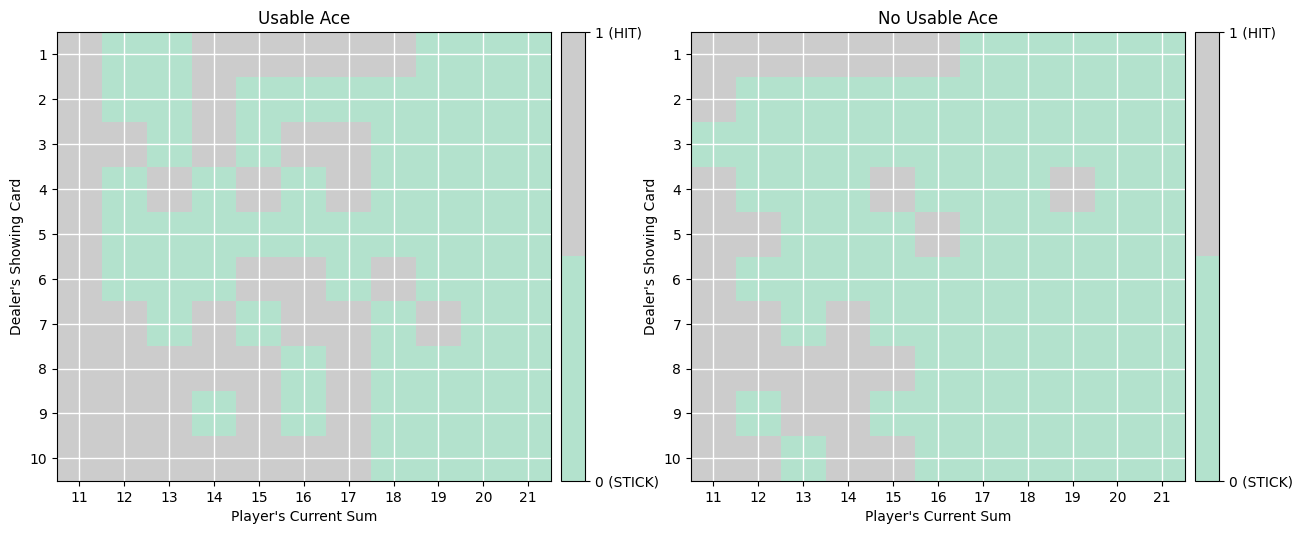

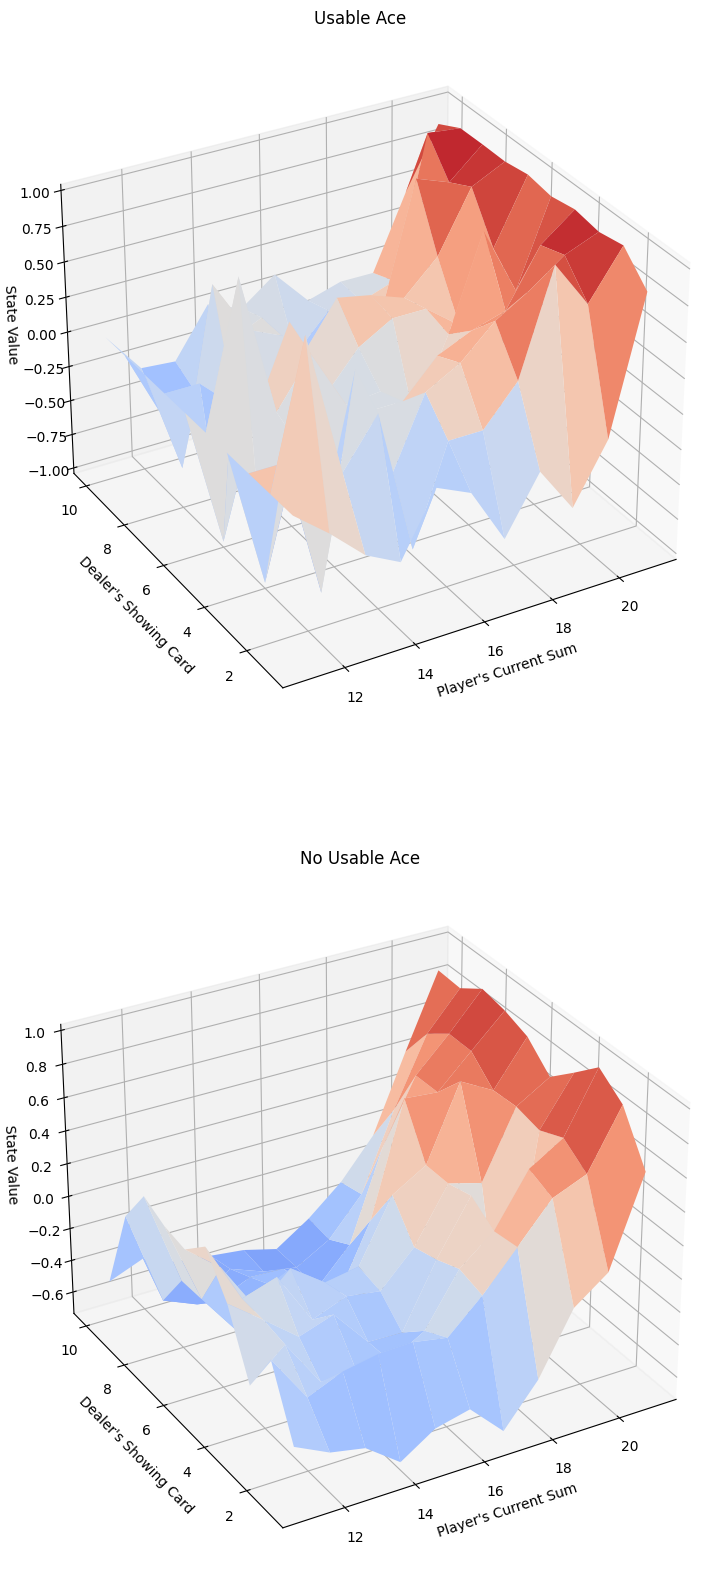

In [11]:
# evaluation
win = 0
for i in range(num_episodes):
    state = env.reset()
    state = state[0]
    while True:
        action = np.argmax(policy[state])
        next_state, reward, done, MDP, info = env.step(action)
        if reward == 1:
            win += 1
        if done:
            break
        state = next_state
print(f'\nWin Rate: {win / num_episodes}')

from plot_utils import *

plot_policy(dict((k, np.argmax(v)) for k, v in Q.items()))
plot_blackjack_values(dict((k, np.max(v)) for k, v in Q.items()))